# Zillow - Exploratory Data Analysis

This file extracts relevant information from the Zillow 2 bedroom data file.

It saves the subset file to disk to be shared amongst other notebooks.

In [33]:
# These configurations expand the Jupyter notebook 
# They also control how much output can be displayed for each cell
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 30)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary python packages
from os import listdir
from os.path import join as pjoin
import pandas as pd
from time import time, sleep
import dateutil.parser

# Import necessary utilities
from Utils.DataUtils import *
from Utils.UtilsViz import *

---------------------------------------------------------------------------------------------------------------

Load the Zillow subset data we saved from the cleaning notebook

In [6]:
zillow_nyc = pd.read_csv("./zillow_nyc_2007_06.csv", index_col="RegionID")
display(zillow_nyc.head())

,CountyName,SizeRank,RegionName,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,New York,1,10025,883400.0,896100.0,923900.0,952900.0,964600.0,972500.0,973800.0,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
61637,New York,3,10023,1411200.0,1407400.0,1419700.0,1457400.0,1500800.0,1524900.0,1537800.0,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
61703,New York,14,10128,1020500.0,1033500.0,1049700.0,1067900.0,1086700.0,1100500.0,1115100.0,...,1526000,1523700,1527200,1541600.0,1557800,1582900,1598900,1646100,1720500,1787100
61625,New York,15,10011,1514600.0,1541900.0,1563500.0,1591300.0,1609900.0,1630300.0,1639200.0,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400
61617,New York,21,10003,1367700.0,1400900.0,1441100.0,1475000.0,1491500.0,1504700.0,1499200.0,...,1932800,1930400,1937500,1935100.0,1915700,1916500,1965700,2045300,2109100,2147000


In [7]:
# Make a few helper variables for future use
zipcode_colname = ["RegionName"]
region_info_cols = ["CountyName", "SizeRank"] + zipcode_colname
year_cols = [c for c in zillow_nyc.columns if c not in region_info_cols]

# Analysis different counties present 

How much data do we have for each county?

In [8]:
cvcs = zillow_nyc["CountyName"].value_counts().to_frame().reset_index()
cvcs.columns = ["County", "num_rows"]
cvcs

,County,num_rows
0,New York,11
1,Richmond,8
2,Kings,5
3,Queens,1


Let's transform the data and get the median price for each county to avoid distribution skew.

By rolling up the data, we should be able to see how median prices for each county changed over time.

In [9]:
county_df = zillow_nyc[["CountyName"]+year_cols].groupby(by="CountyName", as_index=True).median()
county_df_t= county_df.transpose()
county_df_t.index = pd.to_datetime(county_df_t.index)
county_df_t.head()

CountyName,Kings,New York,Queens,Richmond
2007-06-01,553600.0,1367700.0,390300.0,324800.0
2007-07-01,545200.0,1400900.0,388500.0,323400.0
2007-08-01,536200.0,1419700.0,384300.0,322850.0
2007-09-01,531100.0,1457400.0,381300.0,322450.0
2007-10-01,524200.0,1491500.0,380700.0,321500.0


Plot the price changes over time

In [16]:
county_df_t.describe().loc["std",:].to_frame()

,std
CountyName,
Kings,220021.970744
New York,189053.745488
Queens,43435.711653
Richmond,17452.565485


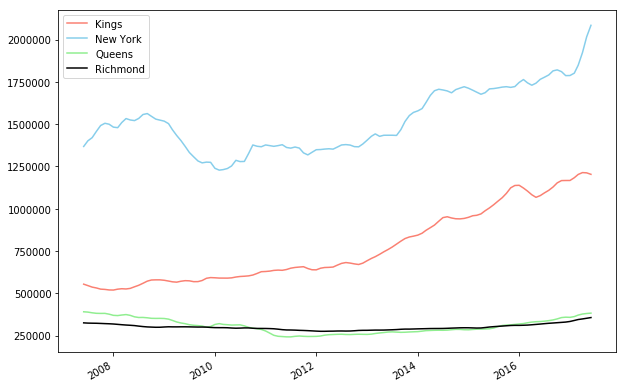

In [29]:
f, ax = plt.subplots(1, 1, figsize=(10,7), sharex=True)
color_map = {"Kings":"salmon", "New York":"skyblue", "Queens":"lightgreen", "Richmond":"black"}    
for c in county_df_t.columns:
    ax.plot_date(county_df_t.index, county_df_t[c], label=c, color=color_map[c], linestyle="-", fmt='-')
ax.legend()
plt.gcf().autofmt_xdate()
plt.show()


<b>New York</b> and <b>Kings</b> are clearly more expensive than <b>Queens</b> and <b>Richmond</b>

Also, as expected, their standard deviation are substantially higher.

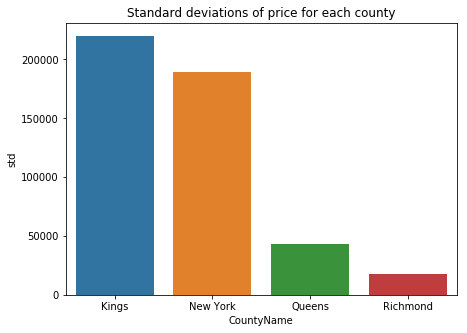

In [28]:
# What about their standard deviations?
c_desc = county_df_t.describe().loc["std",:].to_frame()
f, ax = plt.subplots(1, 1, figsize=(7,5), sharex=True)
g = sns.barplot(x=c_desc.index, y="std", data=c_desc, ax=ax).set(title="Standard deviations of price for each county")

Let's have a look at the delta prices.

To do this, we just subtract a value later in time from its predecessor. 

This allows us to compare the change between prices within county, over time.

In [30]:
counties = county_df_t.columns
for c in counties:
    county_df_t[c+"_delta"] = county_df_t[c].diff()
county_df_t.head()

CountyName,Kings,New York,Queens,Richmond,Kings_delta,New York_delta,Queens_delta,Richmond_delta
2007-06-01,553600.0,1367700.0,390300.0,324800.0,NaN,NaN,NaN,NaN
2007-07-01,545200.0,1400900.0,388500.0,323400.0,-8400.0,33200.0,-1800.0,-1400.0
2007-08-01,536200.0,1419700.0,384300.0,322850.0,-9000.0,18800.0,-4200.0,-550.0
2007-09-01,531100.0,1457400.0,381300.0,322450.0,-5100.0,37700.0,-3000.0,-400.0
2007-10-01,524200.0,1491500.0,380700.0,321500.0,-6900.0,34100.0,-600.0,-950.0


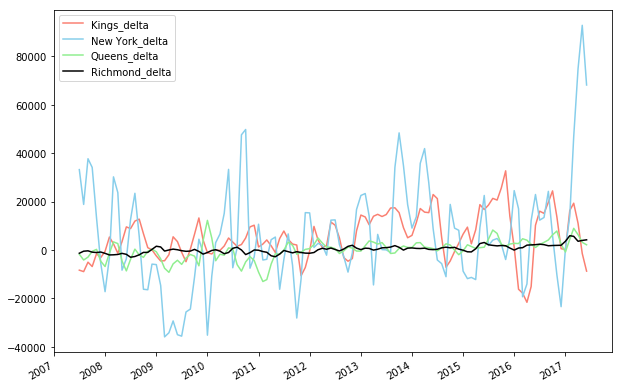

In [117]:
f, ax = plt.subplots(1, 1, figsize=(10,7), sharex=True)
color_map_delta = {"Kings_delta":"salmon", "New York_delta":"skyblue", "Queens_delta":"lightgreen", "Richmond_delta":"black"}
for c in county_df_t.columns:
    if "_delta" not in c:
        continue
    ax.plot_date(county_df_t.index, county_df_t[c], label=c, color=color_map_delta[c], linestyle="-", fmt='-')
ax.legend()
plt.gcf().autofmt_xdate()
plt.show()

**New York** has substantial fluctuation in prices! 

**Kings** seem more stable. 

**Queens** and **Richmond** are also fairly stable in comparison.

Standard deviation plots can confirm this numerically.

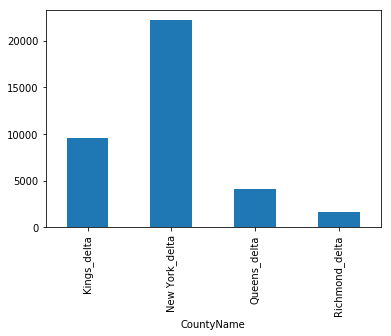

In [31]:
delta_cols = [c for c in county_df_t.columns if "delta" in c]
g = county_df_t[delta_cols].describe().loc["std",:].plot(kind="bar")

The amount of variation in the median pricing of NY is far more than the variation in Kings

Thoughts :

**Kings** and **New York** clearly are more expensive than **Queens** and **Richmond** by a substantial margin. 

However the variance in curred in the delta values of **Kings** is much less than the variance of the **New York** price delta value.

The property prices in **Kings** has been much more steadily rising than in **New York**

-------------

## Variation of prices within county over time, across zipcodes

It may be insightful to see how stable the prices were within each county across the zipcodes, over time.

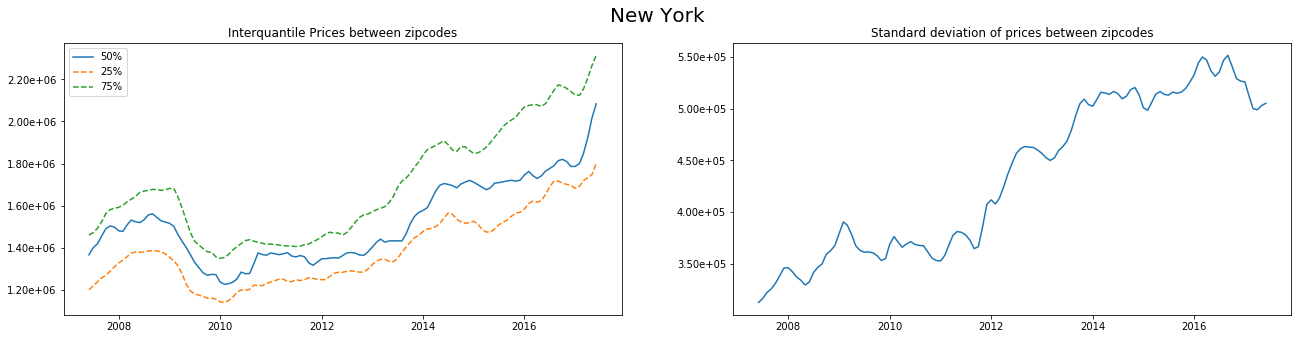

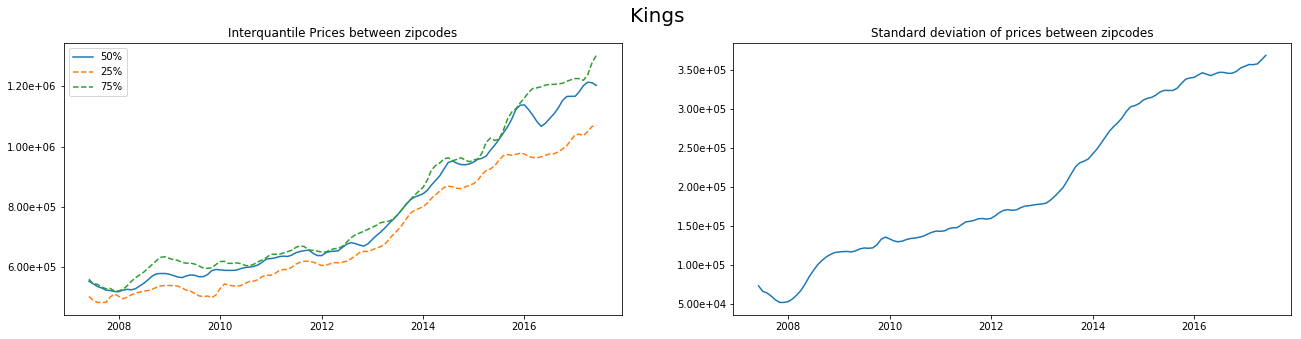

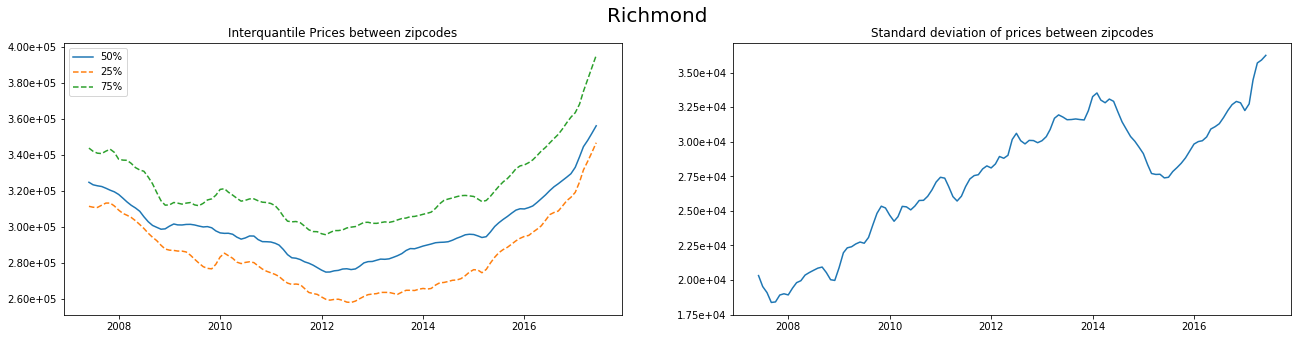

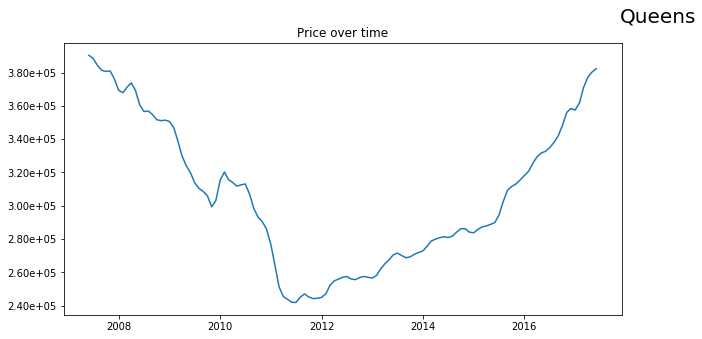

In [38]:
for c in zillow_nyc["CountyName"].unique():
    q = "CountyName==\"" + c + "\""
    county_c = zillow_nyc.query(q)
    
    # NOTE : We only have one data point for Queens. 
    # So we will not be plotting standard deviation between zipcodes over time.
    if "Queens" in q:
        f, ax = plt.subplots(1,2,figsize=(22,5))
        ax[0].plot_date(pd.to_datetime(year_cols), 
                 county_c[year_cols].values.ravel(), linestyle="-", fmt='-')
        ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
        ax[1].set(visible=False)
        ax[0].set(title="Price over time")
        f.suptitle(c, fontsize=20)
        continue
    cny_desc = county_c[year_cols].describe()
    f, ax = plt.subplots(1,2,figsize=(22,5))
    
    ax[0].plot_date(pd.to_datetime(cny_desc.loc["50%",:].index), 
                 cny_desc.loc["50%",:].values, label="50%", linestyle="-", fmt='-')
    ax[0].plot_date(pd.to_datetime(cny_desc.loc["25%",:].index), 
                 cny_desc.loc["25%",:].values, label="25%", linestyle="--", fmt='-')
    ax[0].plot_date(pd.to_datetime(cny_desc.loc["75%",:].index), 
                 cny_desc.loc["75%",:].values, label="75%", linestyle="--", fmt='-')
    ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

    ax[1].plot_date(pd.to_datetime(cny_desc.loc["std",:].index), 
                 cny_desc.loc["std",:].values, linestyle="-", fmt='-')
    ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    
    ax[0].set(title="Interquantile Prices between zipcodes")
    ax[1].set(title="Standard deviation of prices between zipcodes")
    
    ax[0].legend()
    f.suptitle(c, fontsize=20)

# **Observations**

- The vairation of prices between the zipcodes for **New York** has increased over time, with a positive skew trending currently.
- **Kings** is also showing a similar trend, with a sudden rise in standard deviation values around 2013. 


There is an upward trend for prices of real estate in all counties, but **New York** and **Kings** are having a much sharper rise than **Queens** or **Richmond**.

While the data is available only till 2017, it is safe to assume that the trends do not deviate from the current pattern.

Property will be expensive in **New York** and **Kings**, however, when paired with Airbnb data, we can estimate the time taken for ROI.